# Togetherflow
**Emergent agent motion dynamics in immersive rooms**

In this notebook, we implement Togetherflow, a computational cognitive model that characterizes the motion pattern of human agents in immersive rooms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


from scipy import stats
from IPython.display import HTML
from numba import njit
from functools import partial

np.set_printoptions(suppress=True)

In [3]:
import tensorflow as tf
import bayesflow as bf
from bayesflow.simulation import Prior, Simulator, GenerativeModel

## Generative Model Definition

The movement of any agent $a = 1, ..., A$ is both related to: 1) its interaction with surrounding neighbors $i = 1, ..., I$, which we call *internal influence*, and 2) their motivation to the surrounding spatial objects $j = 1, ..., J$, which we call *external influence*. These influences are modulated by a stationary weight, $w_a$:

\begin{equation}
    \theta_{a, t} = w_a \theta_{a|j, t} + (1 - w_a) \theta_{a|i, t}.
\end{equation}

### Meta-Variables

First, we define some meta-variables, such as the number of agents to simulate, the number of spatial beacons present in the environment, etc.

In [4]:
num_agents = 12
num_beacons = 2
room_size = (8., 10.)
world_size = 25.

### Agent Initialization

First, we initialize the agents with a randomized position and orientation, both uniformly distributed.

In [240]:
@njit
def initialize_agents(
    num_agents: int = 12, 
    room_size: tuple = (8., 10.),
):
    """
    Generate random positions and orientations for agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100.0).

    Returns
    -------
    tuple of np.ndarray
        A tuple containing the positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    # Generate random positions within the boundary size centered at 0
    x = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[0]
    y = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[1]
    positions = np.vstack((x, y)).T
    
    # Generate random orientations (angles in radians between 0 and 2*pi)
    rotations = np.random.random(size=(num_agents, )).astype(np.float32) * np.pi * 2
    
    return positions.astype(np.float32), rotations.astype(np.float32)

In [241]:
agent_positions, agent_rotations = initialize_agents(room_size=room_size)
agent_positions

array([[-3.8494356 , -0.724504  ],
       [ 0.5585656 , -3.372385  ],
       [-2.826189  , -4.5933776 ],
       [ 3.0889635 , -1.8855956 ],
       [-1.1686695 ,  1.9426423 ],
       [ 3.1150293 ,  3.6429124 ],
       [-3.521662  , -2.6604228 ],
       [-0.01404285,  1.6491759 ],
       [ 0.54157066, -2.0616424 ],
       [-2.5922256 , -0.25435776],
       [-0.25806355,  1.0972065 ],
       [ 1.9866261 ,  1.898427  ]], dtype=float32)

Text(0, 0.5, 'y')

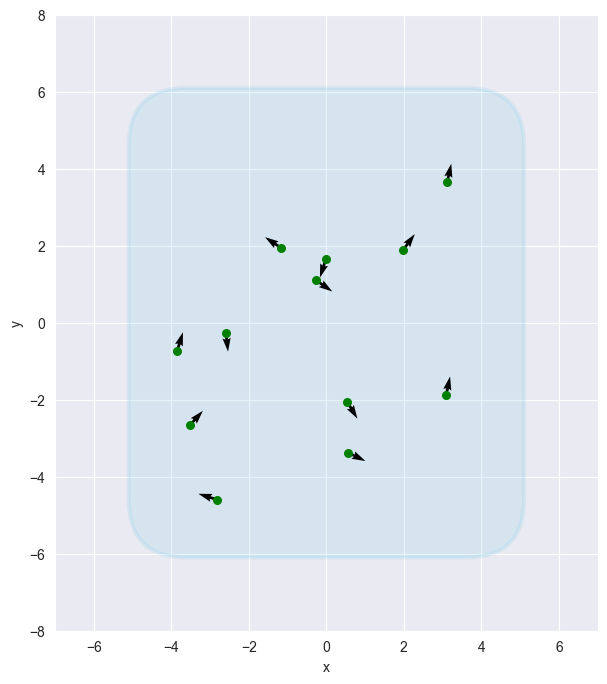

In [243]:
from matplotlib.patches import FancyBboxPatch

fig, ax = plt.subplots(1, 1, figsize=(7, 8))

# Create a rounded rectangle with translucent face color
rounded_rect = FancyBboxPatch(
    (-5, -6),       # Lower left corner
    width=10.,        # Width
    height=12.,       # Height
    boxstyle="round,pad=0.1,rounding_size=1.5",  # Rounded box
    edgecolor=(0.53, 0.81, 0.92, 1),
    facecolor=(0.53, 0.81, 0.92, 0.2),
    linewidth=3,
    alpha=0.2         # Set opacity level (0 is fully transparent, 1 is fully opaque)
)

ax.add_patch(rounded_rect)
ax.quiver(
    agent_positions[:, 0], agent_positions[:, 1], 
    np.cos(agent_rotations), np.sin(agent_rotations), 
    angles='xy', scale_units="xy", 
    scale=2, width=0.005
)
ax.scatter(agent_positions[:, 0], agent_positions[:, 1], c='g', s=30)
ax.set_xlim([-7, 7])
ax.set_ylim([-8, 8])
ax.set_xlabel('x')
ax.set_ylabel('y')

### Beacon initialization

To intrinsically motivate the agents, we need a set of virtual beacons that are populated within the environment. The beacons have a freer representation with only positions needed.

In [347]:
@njit
def initialize_beacons(
        num_beacons = 10,
        room_sensing_range = 50.
):
    
    """
    Initialize beacons following a uniform distribution scaled to the room's sensing boundary
    
    Parameters
    ----------
    num_beacons : int, default: 10
        Number of beacons to initialize.
    room_sensing_range : float, default: 50.0
        Sensing distance of the room for the beacons to matter.
    
    Returns 
    -------
    beacons      : np.ndarray of shape (num_beacons, 2)
        Initial positions of the beacons. 
    """
    
    beacons = (np.random.random(size=(num_beacons, 2)) - 0.5) * room_sensing_range
    return beacons.astype(np.float32)

In [348]:
beacon_positions = initialize_beacons(num_beacons=6, room_sensing_range=world_size)
beacon_positions

array([[ 1.7625506, -3.0083506],
       [11.858733 , 10.319084 ],
       [ 3.4271228,  4.505584 ],
       [-7.3525496, -5.8183093],
       [-8.257162 ,  5.5173955],
       [ 9.117816 ,  1.539544 ]], dtype=float32)

Text(0, 0.5, 'y')

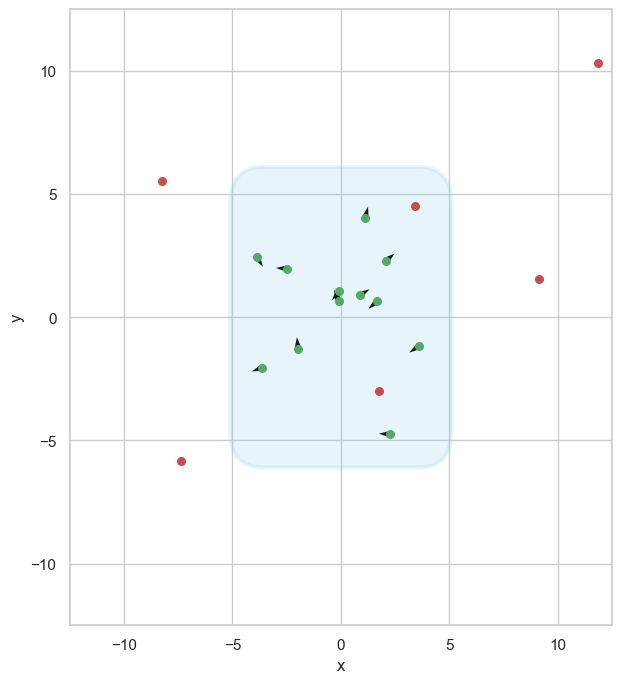

In [349]:
fig, ax = plt.subplots(1, 1, figsize=(7, 8))

# Create a rounded rectangle with translucent face color
rounded_rect = FancyBboxPatch(
    (-5, -6),       # Lower left corner
    width=10.,        # Width
    height=12.,       # Height
    boxstyle="round,pad=0.1,rounding_size=1.5",  # Rounded box
    edgecolor=(0.53, 0.81, 0.92, 1),
    facecolor=(0.53, 0.81, 0.92, 0.2),
    linewidth=3,
    alpha=0.2         # Set opacity level (0 is fully transparent, 1 is fully opaque)
)

ax.add_patch(rounded_rect)
ax.quiver(
    agent_positions[:, 0], agent_positions[:, 1], 
    np.cos(agent_rotations), np.sin(agent_rotations), 
    angles='xy', scale_units="xy", 
    scale=2, width=0.005
)
ax.scatter(agent_positions[:, 0], agent_positions[:, 1], c='g', s=30)
ax.scatter(beacon_positions[:, 0], beacon_positions[:, 1], c='r', s=30)
ax.set_xlim([-0.5 * world_size, 0.5 * world_size])
ax.set_ylim([-0.5 * world_size, 0.5 * world_size])
ax.set_xlabel('x')
ax.set_ylabel('y')

## External Influence: drift-diffusion vector

We want to compute the influence of agent movement direction within a single time step. For this, we specify our internal influence as a 2D drift diffusion model, where the agents are approach a spatial beacon within the room's boundary by reorienting its locomotive direction.

\begin{equation}
    \theta_{a|j, t} = \theta_{a|j, t-1} + \omega_a \mathrm{d}t + \mathrm{d}\phi_t,
\end{equation}

\begin{align}
    \mathrm{d}\mathbf{x}_{a|j, t} 
    &= v_{a|j}\mathrm{d}t \frac{\mathbf{x}_{a|j}}{||\mathbf{x}_{a|j}||} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t \\
    &= v_{a}\mathrm{d}t     
    \begin{bmatrix}
        \cos \theta_{a|j, t} \\
        \sin \theta_{a|j, t}
    \end{bmatrix} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t,% \sqrt{\mathrm{d}t} Z_t.
\end{align}

In [352]:
@njit
def external_influence( 
    agent_position,
    target_position,
    focus = 8.
):
    """
    Generate a drift-diffusion vector in 2D space for a single agent 
    based on a target location (in this case, the position of a beacon).

    Parameters
    ----------
    agent_position : np.ndarray
        The position of the agent.
    target_position : np.ndarray
        The position of the target beacon.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.

    Returns
    -------
    np.ndarray
        A 2D vector representing the drift-diffusion process towards the target (beacon).
    """
    # Calculate the angle towards the beacon (in radian)
    target_angle = np.arctan2(
        target_position[1] - agent_position[1], 
        target_position[0] - agent_position[0]
    )
    
    # Generate a random direction with drift around the target angle
    direction = np.random.vonmises(mu=target_angle, kappa=focus)
    
    # Convert the angle to a unit vector in 2D space
    v = np.array([np.cos(direction), np.sin(direction)], dtype=np.float32)
    
    return v

## Internal Influence: particle dynamics

Its influence by a collective group of agents is modeled as a self-propelling particle system, as expressed in the Vicsek model:

\begin{align}
    \theta_{a|i, t} &= \langle \theta_{i, t}\rangle_{|\mathbf{x}_a - \mathbf{x}_i| < r_a, i \in I} + \eta_{a,t-1}, \\
    \mathrm{d} \mathbf{x}_{a|i,t} &= v_{a,t} \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{a|i, t} \\
        \sin \theta_{a|i, t}
    \end{bmatrix},
\end{align}

In [354]:
@njit 
def internal_influence(
        self_position,
        other_positions,
        other_rotations,
        sensing_radius = 1.5,
        focus = 8.
):
    """
    Generate an influence vector for a single agent 
    based on the angular component of the Vicsek model.

    Parameters
    ----------
    self_position : np.ndarray of shape (2,)
        A 2D vector representing the position of the agent
    neighbor_positions : np.ndarray of shape (2,)
        A 2D vector representing the positions of the neighboring agents.
    neighbor_rotations : np.ndarray of shape (2,)
        A 2D vector representing the rotations of the neighboring agents.
    sensing_radius : float
        The sensing radius within which agents interact with their neighbors.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.

    Returns
    -------
    np.ndarray
        A 2D unit vector representing the averaged influence direction with added noise.
    """
      
    neighbor_rotations = []
    
    for i in range(len(other_positions)):
        dx = other_positions[i, 0] - self_position[0]
        dy = other_positions[i, 1] - self_position[1]
        d = (dx ** 2 + dy ** 2) ** 0.5
        
        if d <= sensing_radius and d > 0:
            neighbor_rotations.append(other_rotations[i])
            
    if len(neighbor_rotations) == 0:
        return np.array([0.0, 0.0], dtype=np.float32)
    
    neighbor_rotations = np.array(neighbor_rotations)
    averaged_rotation = np.sum(neighbor_rotations) / len(neighbor_rotations)
    
    noise = np.random.vonmises(mu=0., kappa=focus)
    direction = averaged_rotation + noise
    
    v = np.array([np.cos(direction), np.sin(direction)], dtype=np.float32) 
    
    return v

## Putting everything together: combined influences

The combined influences allow us to update the agents' positions and rotations together.

In [358]:
@njit
def update_agents(
    agent_positions: np.ndarray = None, 
    agent_rotations: np.ndarray = None,
    beacon_positions: np.ndarray = None,
    velocity: float = 1.0, 
    sensing_radius: float = 2.5,
    dt: float = 0.1, 
    influence_weight: float = 0.5,
    external_focus: float = 0.1,
    internal_focus: float = 0.1
):
    """
    Update the positions and orientations of a single agent 
    based on velocity and influence vectors.

    Parameters
    ----------
    agent_positions : np.ndarray
        Current positions of the agents.
    agent_rotations : np.ndarray
        Current orientations of the agents.
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    sensing_radius : float, optional
        The sensing radius within which agents interact with their neighbors.
    dt : float, optional
        The time step for updating positions and orientations (default is 0.1).
    influence_weight : float, optional
        The weight of influence_vector1 in determining new orientations (default is 0.7).

    Returns
    -------
    tuple of np.ndarray
        Updated positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """
    
    assert (len(agent_positions) == len(agent_rotations))
    
    num_agents = agent_positions.shape[0]
    num_beacons = beacon_positions.shape[0]
    
    # Create new numpy arrays for the updated agent positions and rotations
    new_agent_positions = np.zeros((num_agents, 2))
    new_agent_rotations = np.zeros((num_agents, ))
    
    for i in range(num_agents):
        # Generate the ddm vector for the agent based on its closest beacon
        distance_to_beacon = []
        
        for b in range(num_beacons):
            bx = beacon_positions[b, 0] - agent_positions[i, 0]
            by = beacon_positions[b, 1] - agent_positions[i, 1]
            distance_to_beacon.append((bx * bx + by * by) ** 0.5)
        
        beacon_id = np.argmin(np.array(distance_to_beacon))
        
        ddm_vector = external_influence(
            agent_positions[i], 
            beacon_positions[beacon_id],
            focus=external_focus
        )
        
        # Generate the vicsek vector for the agent based on its neighbors (all agents)
        vicsek_vector = internal_influence(
            self_position=agent_positions[i],
            other_positions=agent_positions,
            other_rotations=agent_rotations,
            sensing_radius=sensing_radius,
            focus=internal_focus
        )

        # Update orientations based on two influence vectors
        ddm_influence = np.arctan2(ddm_vector[1], ddm_vector[0])
        vicsek_influence = np.arctan2(vicsek_vector[1], vicsek_vector[0])
        
        # Combine influences to update orientations with different weights
        new_agent_rotations[i] = agent_rotations[i] + (influence_weight * ddm_influence + (1 - influence_weight) * vicsek_influence) * dt
        
        # Ensure orientations are within the range [0, 2*pi]
        new_agent_rotations[i] = np.mod(new_agent_rotations[i], 2 * np.pi)
        
        # Update positions based on current orientations
        new_agent_positions[i, 0] = agent_positions[i, 0] + velocity * np.cos(new_agent_rotations[i].item()) * dt
        new_agent_positions[i, 1] = agent_positions[i, 1] + velocity * np.sin(new_agent_rotations[i].item()) * dt
    
    return new_agent_positions, new_agent_rotations

In [359]:
agent_positions, agent_rotations = initialize_agents(12, room_size=room_size)
beacon_positions = initialize_beacons(num_beacons=2)
new_agent_positions, new_agent_rotations = update_agents(agent_positions, agent_rotations, beacon_positions)

In [360]:
np.concatenate([agent_positions, new_agent_positions], axis=1)

array([[-3.66947222, -3.55204606, -3.71396701, -3.6416017 ],
       [ 0.06731558,  3.32177114,  0.03651404,  3.41690928],
       [ 3.68566322, -1.5364697 ,  3.61950419, -1.61145624],
       [-0.03476286,  4.28923178, -0.04565791,  4.18982706],
       [ 3.09771109,  3.68794084,  3.18283358,  3.74042094],
       [ 2.23712254,  3.31675649,  2.24652327,  3.21719934],
       [-1.25684285, -0.77686101, -1.22709051, -0.87233246],
       [ 3.1580019 , -0.63644111,  3.08993107, -0.70969657],
       [-2.00387073, -4.03446579, -2.09283485, -4.08013181],
       [ 3.37169123,  3.22278857,  3.2717994 ,  3.22743855],
       [ 3.12425995, -1.31407976,  3.03968265, -1.26072547],
       [-1.22088194,  4.66290188, -1.30877169,  4.71060294]])

In [361]:
np.vstack([agent_rotations, new_agent_rotations]).T

array([[4.2777791 , 4.25127287],
       [1.8713727 , 1.88390262],
       [4.10669231, 3.98945132],
       [4.69358253, 4.60322174],
       [0.46297014, 0.55248136],
       [4.74745798, 4.80653533],
       [5.12675571, 5.01448652],
       [3.99386644, 3.96365987],
       [3.53323674, 3.61583008],
       [3.12988973, 3.09507613],
       [2.53184962, 2.57880861],
       [2.58858848, 2.64434244]])

## Simulation Loop

The update allows us to continuously simulate the agents' positions and rotations at a given interval

In [362]:
@njit
def simulator_fun(
    theta = None,
    num_agents: int = 12, 
    num_beacons: int = 1,
    room_size: tuple = (8, 10),
    velocity: float = 1.0, 
    dt: float = 0.1, 
    influence_weight: float = 0.7, 
    sensing_radius: float = 10.0,
    external_focus: float = 0.1,
    internal_focus: float = 0.1,
    num_timesteps: int = 1000
):
    """
    Run the simulation and store the time series of positions and orientations of agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    num_beacons : int, optional
        Number of beacons to generate (default is 1).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100).
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    dt : float, optional
        The time step for the update (default is 0.1).
    influence_weight : float, optional
        The weight for influence_vector1 in determining new orientations (default is 0.7).
    sensing_radius : float, optional
        The sensing radius for the Vicsek model (default is 10.0).
    num_timesteps : int, optional
        The number of steps to simulate (default is 100).

    Returns
    -------
    tuple of np.ndarray
        The time series of positions and orientations of the agents.
    """
    
    if theta is not None:
        influence_weight = theta[0]
        sensing_radius = theta[1]
        velocity = theta[2]
        external_noise = theta[3]
        internal_noise = theta[4]
    
    
    # Initialize positions and orientations
    initial_positions, initial_rotations = initialize_agents(num_agents, room_size=room_size)

    # Initialize arrays to store time series of positions and orientations
    positions = np.zeros((num_timesteps, num_agents, 2))
    rotations = np.zeros((num_timesteps, num_agents, ))
    positions[0] = initial_positions
    rotations[0] = initial_rotations
    
    # Initialize beacons
    beacon_positions = initialize_beacons(num_beacons)

    # Simulation loop
    for t in range(1, num_timesteps):
        ps, rs = update_agents(
            agent_positions=positions[t-1], 
            agent_rotations=rotations[t-1], 
            beacon_positions=beacon_positions, 
            velocity=velocity, 
            sensing_radius=sensing_radius, 
            dt=dt, 
            influence_weight=influence_weight,
            external_focus=external_focus,
            internal_focus=internal_focus
        )
        
        # Store positions and orientations for each time step
        positions[t] = ps
        rotations[t] = rs
    
    rotations = rotations[:,:,np.newaxis]

    return np.concatenate((positions, rotations), axis=-1)

In [363]:
out = simulator_fun(num_agents=12, num_beacons=2, influence_weight=1., num_timesteps=100)
out.shape

(100, 12, 3)

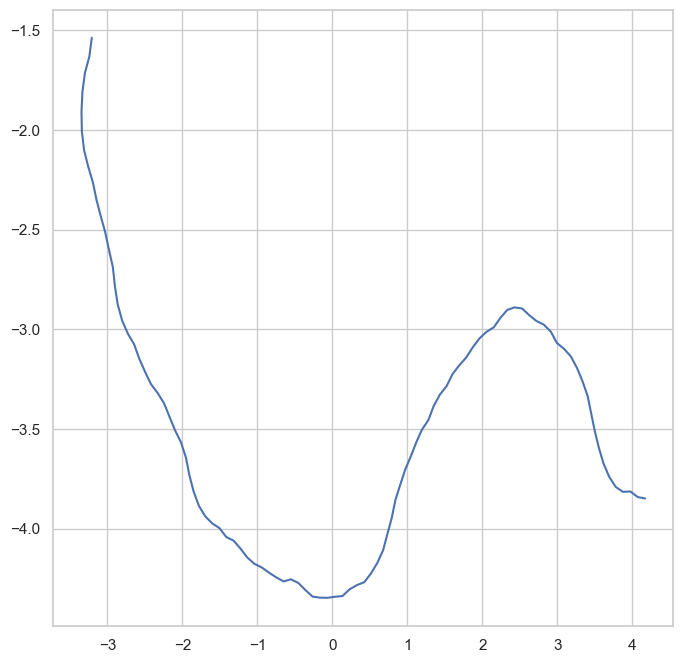

In [364]:
positions = out[:, :, 0:2]

f, ax = plt.subplots(1, 1, figsize=(8,8))
f = ax.plot(positions[:,1,0], positions[:,1,1], c='b')

# Complete pooling priors

In [368]:
param_names = [
    r"$w_a$",
    r"$r_a$",
    r"$v_a$",
    r"$\eta_a$",
    r"$\omega_a$"
]

In [386]:
@njit
def prior_fun():
    weight = np.random.beta(2, 2)
    radius = np.random.gamma(2, 0.2)
    v = np.random.beta(2, 2)
    external_focus = np.random.gamma(9., 0.5)
    internal_focus = np.random.gamma(9., 0.5)
    return np.array([weight, radius, v, external_focus, internal_focus])

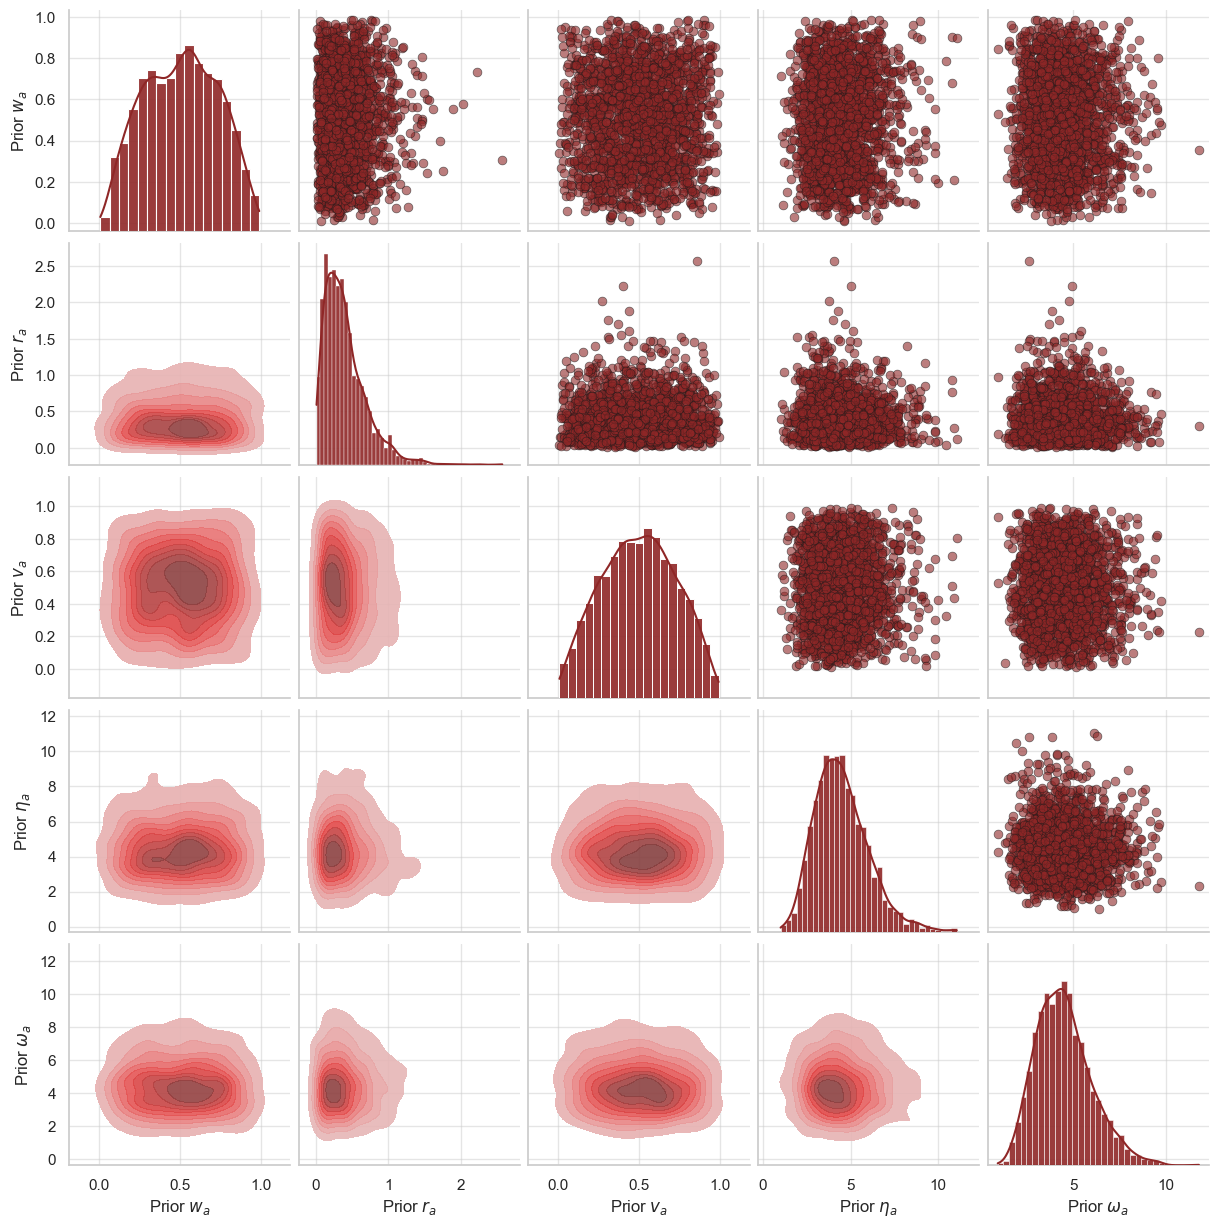

In [387]:
prior = Prior(prior_fun=prior_fun, param_names=param_names)
pp_check = prior.plot_prior2d()

# Generative Model

In [393]:
simulator = Simulator(simulator_fun=partial(simulator_fun, num_timesteps=1001))
simulator

In [394]:
model = GenerativeModel(
    prior=prior,
    simulator=simulator,
    simulator_is_batched=False,
    name="TogetherFlow"
)

INFO:root:Performing 2 pilot runs with the TogetherFlow model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1001, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Configurator

In [395]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

# Neural Approximator

In [396]:
# This one generalizes over different numbers of agents
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=5, 
    num_coupling_layers=6,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)


amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)

# Training

In [397]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


### Online Training

In [399]:
history = trainer.train_online(epochs=1, batch_size=32, iterations_per_epoch=10)

Training epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

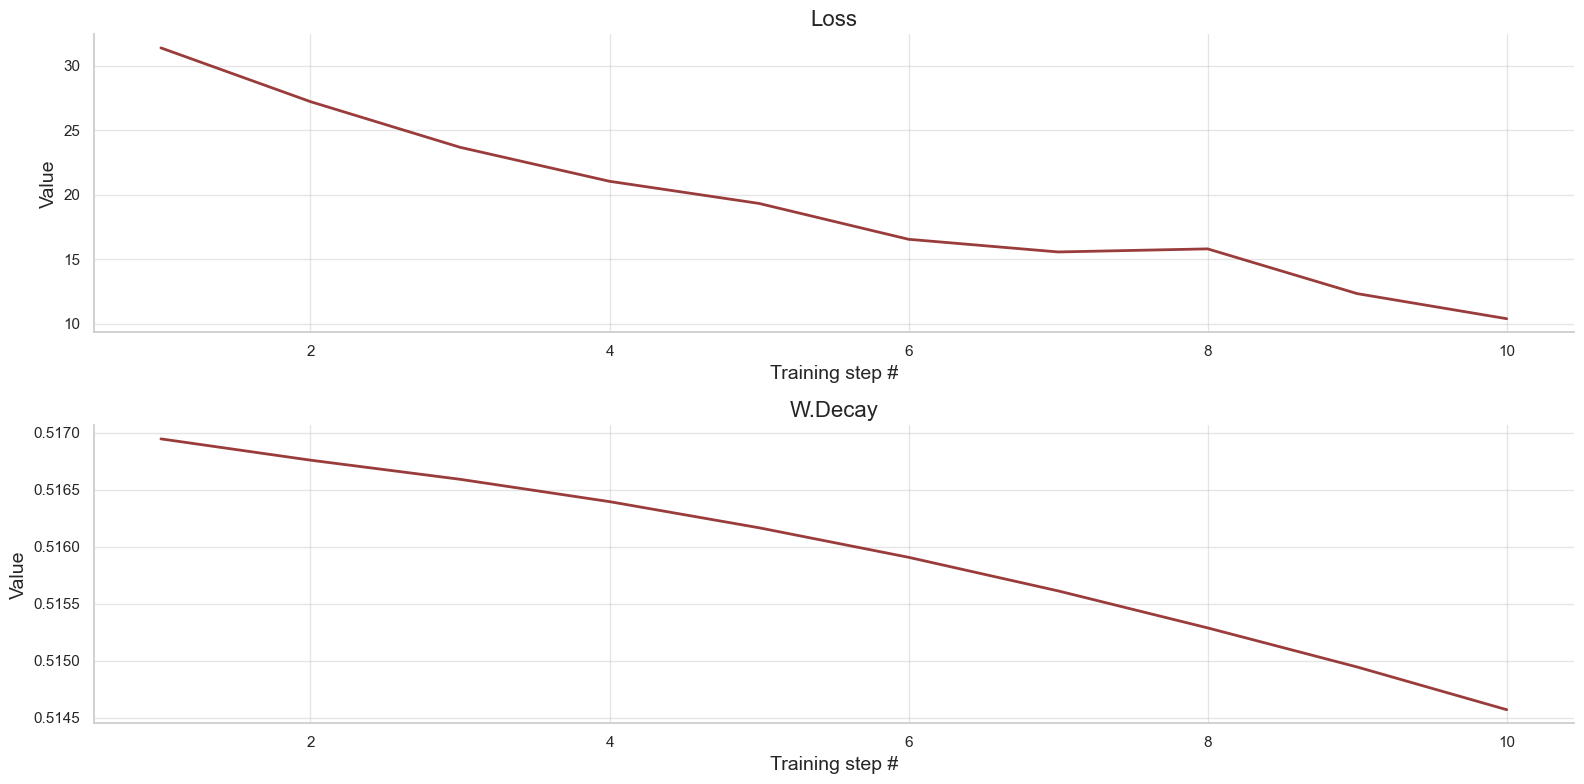

In [400]:
f = bf.diagnostics.plot_losses(history)

### Validation

In [378]:
validation_sim = model(400)
validation_configured = configurator(validation_sim)

In [379]:
validation_configured["parameters"]

array([[ 0.31652597,  1.0847167 ,  0.8478187 , -0.7192689 ,  0.3488312 ],
       [ 0.76992893,  0.50682515,  0.74404776, -0.20447299, -0.09238146],
       [ 0.76348436,  0.5296142 ,  0.82450235,  0.43998283, -0.02666565],
       ...,
       [ 0.3273034 ,  0.13233717,  0.45152476, -0.12837656, -0.04001725],
       [ 0.1627248 ,  0.21394753,  0.1351087 , -0.54084903,  0.4824753 ],
       [ 0.3659444 ,  0.724101  ,  0.73106337,  0.22473219, -0.15423869]],
      dtype=float32)

In [380]:
post_samples = amortizer.sample(validation_configured, n_samples=1000)
prior_samples = validation_configured["parameters"]

# Parameter Recovery

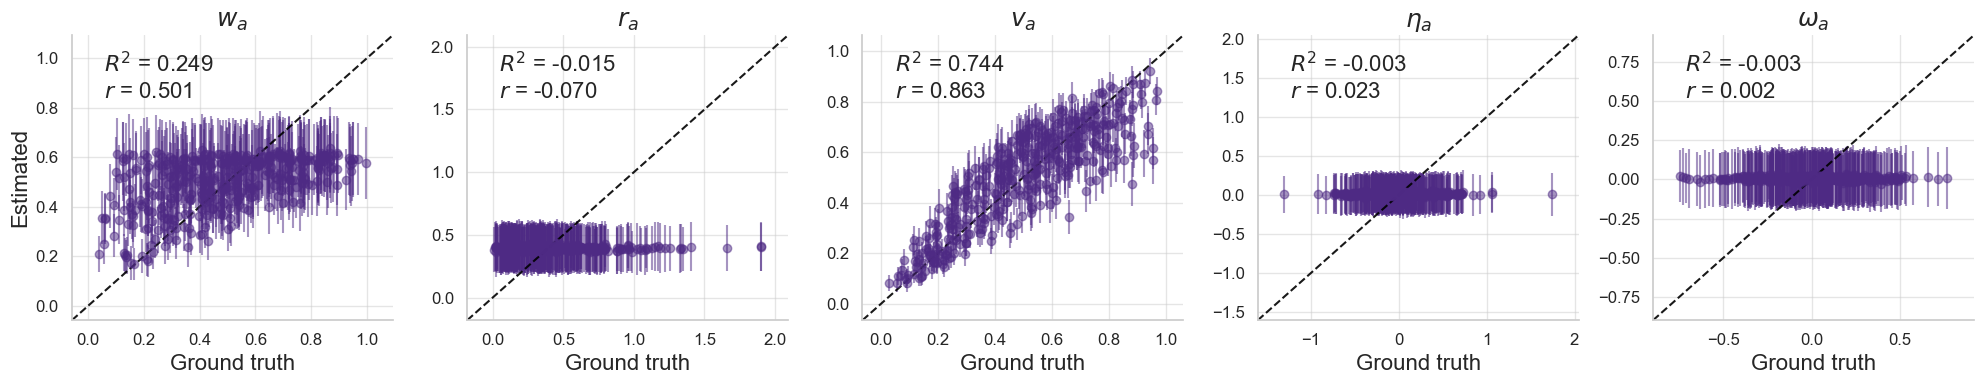

In [381]:
sns.set(rc={'axes.facecolor':'#FFFFFF00', 'figure.facecolor':'#FFFFFF00'})
sns.set_style('whitegrid')

g = bf.diagnostics.plot_recovery(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names,
    color="#4E2A84"
)

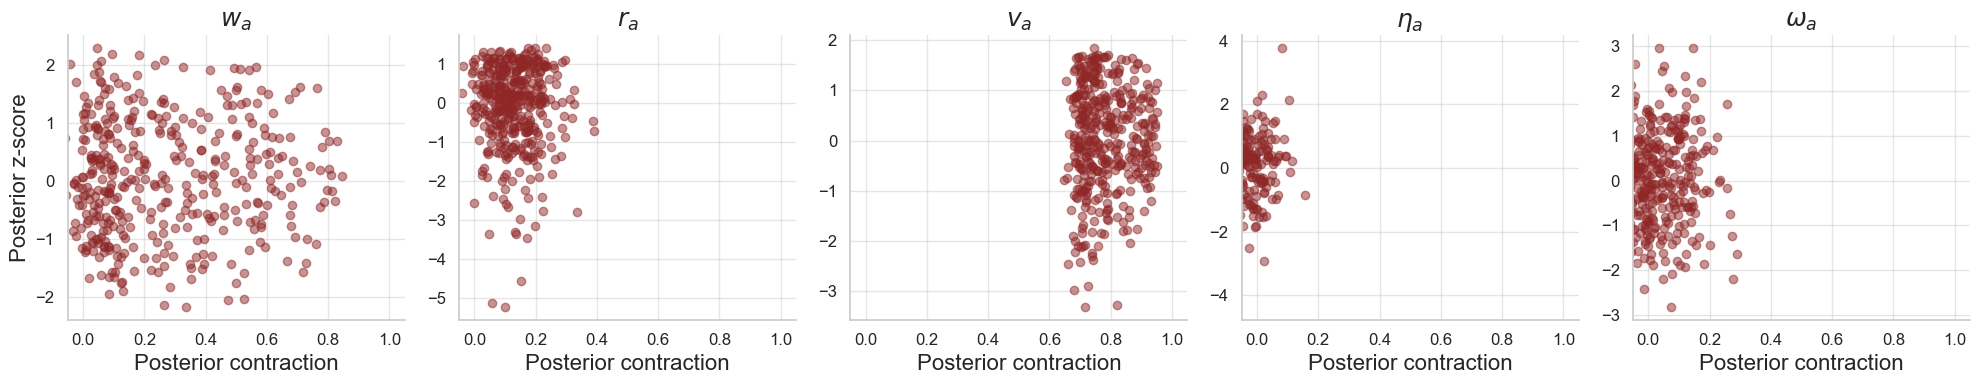

In [382]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

# SBC

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


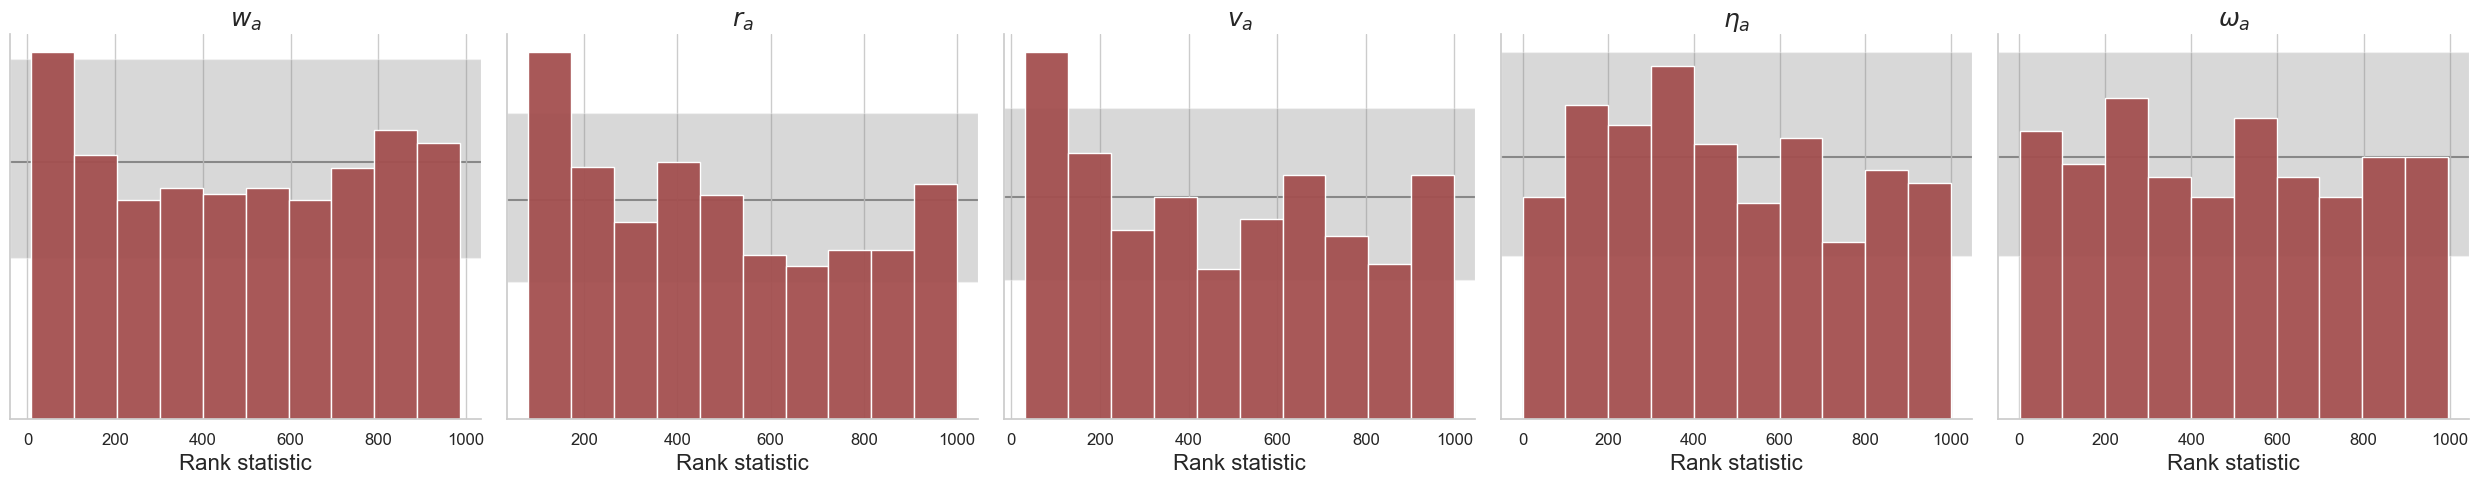

In [383]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

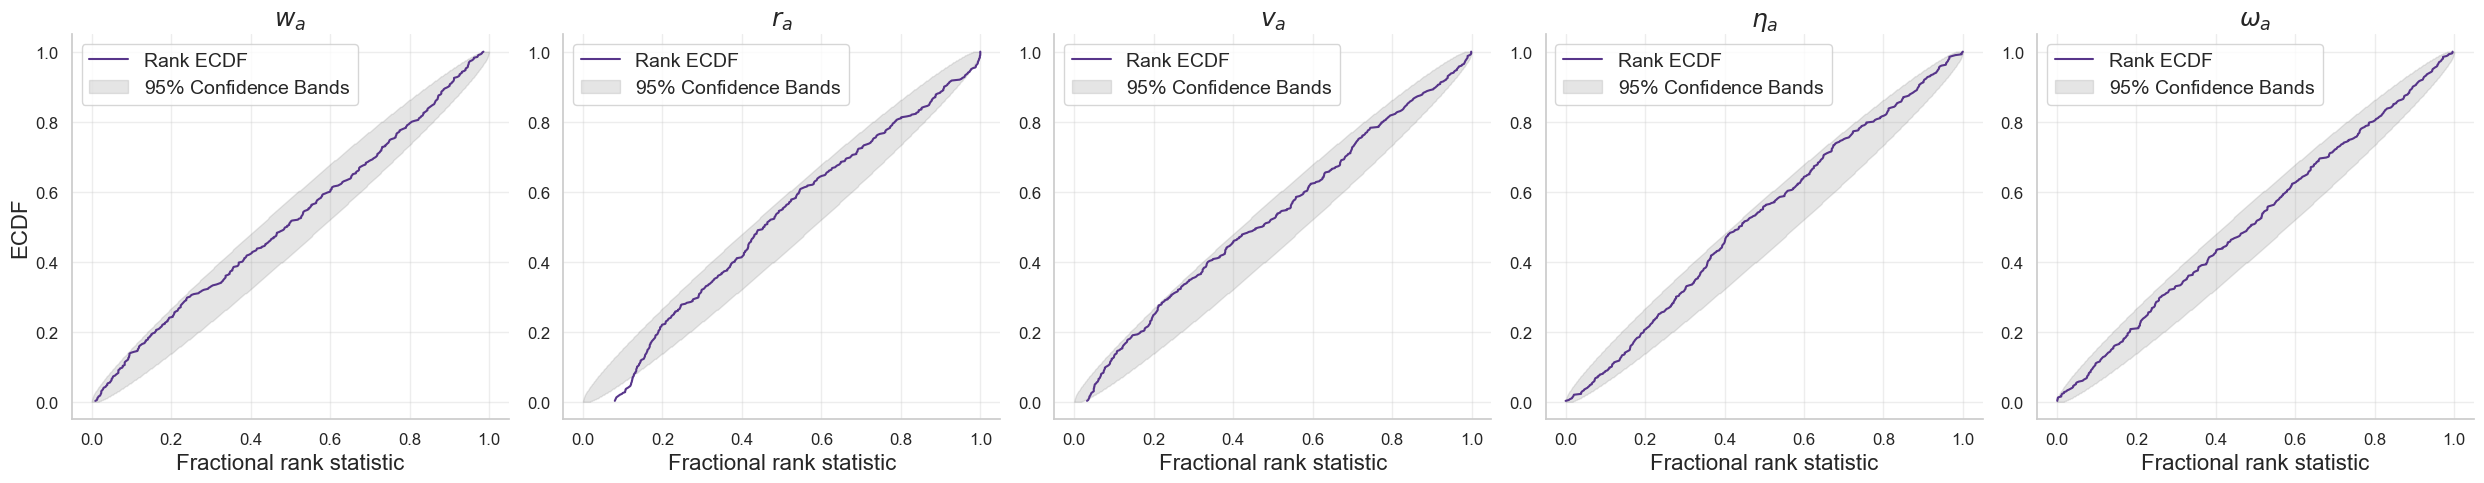

In [384]:
e = bf.diagnostics.plot_sbc_ecdf(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names, 
    rank_ecdf_color="#4E2A84"
)

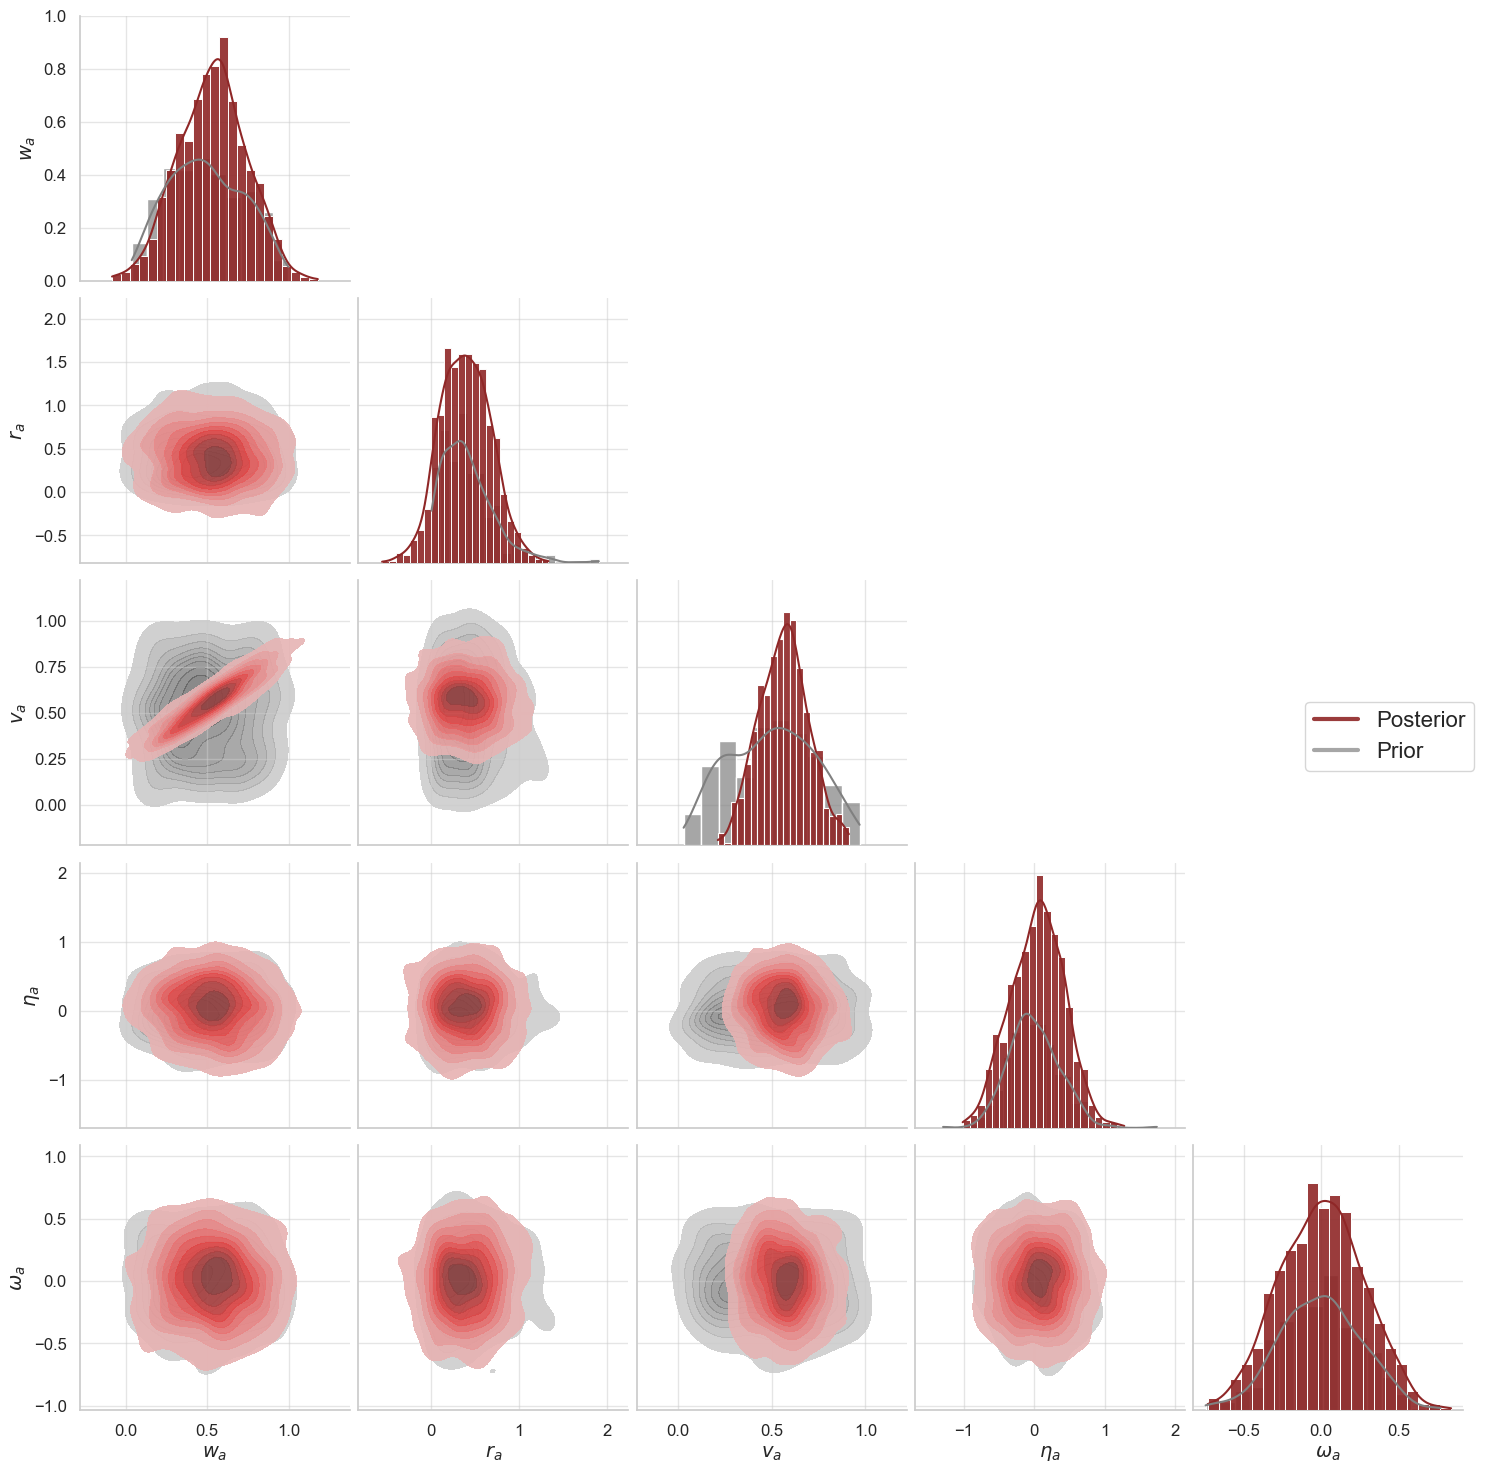

In [385]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[1], prior_draws=prior_samples, param_names=param_names)